In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
def create_partial_datasets(classes):
    train_data = datasets.MNIST(
        root = 'data',
        train = True,                         
        transform = ToTensor(), 
        download = True        
    )
    test_data = datasets.MNIST(
        root = 'data', 
        train = False, 
        transform = ToTensor()
    )
    
    # We need to make sure that labels always start at 0
    mapping = {old: new for new, old in enumerate(classes)}
    
    # Filter and map the training dataset
    train_idx = [i for i, label in enumerate(train_data.targets) if label in classes]
    train_data.data = train_data.data[train_idx]
    train_data.targets = torch.tensor([mapping[label.item()] for label in train_data.targets[train_idx]])
    
    # Filter and map the testing dataset
    test_idx = [i for i, label in enumerate(test_data.targets) if label in classes]
    test_data.data = test_data.data[test_idx]
    test_data.targets = torch.tensor([mapping[label.item()] for label in test_data.targets[test_idx]])
    
    return train_data, test_data

In [30]:
first_five_classes = [0, 1, 2, 3, 4]
last_five_classes = [5, 6, 7, 8, 9]

first_5_train_data, first_5_test_data = create_partial_datasets(first_five_classes)
last_5_train_data, last_5_test_data = create_partial_datasets(first_five_classes)

# MNIST train contains 60'000 images, while test contains 70'000 images
loaders = {
    'first_5_train' : torch.utils.data.DataLoader(first_5_train_data, batch_size=50, shuffle=True, num_workers=1),
    'first_5_test'  : torch.utils.data.DataLoader(first_5_test_data, batch_size=50, shuffle=True, num_workers=1),
    
    'last_5_train' : torch.utils.data.DataLoader(last_5_train_data, batch_size=50, shuffle=True, num_workers=1),
    'last_5_test'  : torch.utils.data.DataLoader(last_5_test_data, batch_size=50, shuffle=True, num_workers=1),
}

In [31]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 5 classes
        # We have 32 channels and at the beginning the image is of size 28x28, using two maxpooling operations of size 2x2
        # we get an image of size 7x7 at the end
        self.out = nn.Linear(32 * 7 * 7, 5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [32]:
def evaluate(model, test_loader):

    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [36]:
def train(num_epochs, train_loader,  model, optimizer, loss_func, test_loader=None, evaluation_indices=None):
    """
    Evaluation_indices specifies the indices of the batches whenever the model should be evaluated
    """
    
    if evaluation_indices is not None:
        test_accuracies = []
        
        if test_loader is None:
            raise ValueError("test_loader cannot be None if evaluation_frequency is not None!")
    
    model.train()
    images_processed = 0
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
                        
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if evaluation_indices is not None and i in evaluation_indices:
                accuracy = evaluate(model, test_loader)
                test_accuracies.append(accuracy)
    
    if evaluation_indices is not None:
        return test_accuracies

In [37]:
num_epochs = 3
num_models = 5

models = [CNN().to(device) for _ in range(num_models)]
optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]
loss_func = nn.CrossEntropyLoss()

for i, model in enumerate(models):
    print(f"Training model [{i+1}/{num_models}]")
    optimizer = optimizers[i]
    
    # Assuming you have a train function that trains a given model
    train(num_epochs, loaders["first_5_train"], model, optimizer, loss_func)

Training model [1/5]
Training model [2/5]
Training model [3/5]
Training model [4/5]
Training model [5/5]


In [38]:
for i, model in enumerate(models):
    acc = evaluate(model, loaders["first_5_test"])
    print(f"Testing model [{i+1}/{num_models}]: {acc}")

Testing model [1/5]: 0.9964973730297724
Testing model [2/5]: 0.9826814555360965
Testing model [3/5]: 0.9928001556723098
Testing model [4/5]: 0.989492119089317
Testing model [5/5]: 0.9949406499318934


In [42]:
def get_average_filters(models, num_clusters):
    filter_vectors = []

    for model in models:
        # Extract the filters from the first convolutional layer
        filters = model.conv1[0].weight.data.cpu().numpy()

        for i in range(filters.shape[0]):
            # Flatten and normalize the filter
            filter_vec = filters[i].flatten()
            filter_vec /= np.linalg.norm(filter_vec)
            filter_vectors.append(filter_vec)
    
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    cluster_labels = kmeans.fit_predict(filter_vectors)
    
    filter_vectors = np.array(filter_vectors)
    
    average_filters = []

    for cluster_num in range(num_clusters):
        
        # Find the indices where the cluster label matches the current cluster number
        indices = np.where(cluster_labels == cluster_num)[0]

        # Filters belonging to the current cluster
        cluster_filters = filter_vectors[indices]

        # Compute the average filter for this cluster
        average_filter = np.mean(cluster_filters, axis=0)
        average_filters.append(average_filter)

    return average_filters

In [43]:
def create_initialized_model(models):
    our_model = CNN().to(device)
    
    average_filters = get_average_filters(models, 16)

    shaped_average_filters = np.array(average_filters).reshape((16, 1, 7, 7))
    shaped_average_filters = torch.tensor(shaped_average_filters, dtype=torch.float32).to(device)

    our_model.conv1[0].weight.data = shaped_average_filters
    
    return our_model

In [ ]:
def compare_models(models, loaders, num_epochs, plot_result=False):
    our_model = create_initialized_model(models)
    random_model = CNN().to(device)
    
    our_optimizer = torch.optim.Adam(our_model.parameters(), lr=0.01)
    random_optimizer = torch.optim.Adam(random_model.parameters(), lr=0.01)
    
    loss_func = torch.nn.CrossEntropyLoss()
    
    our_accuracies = train(num_epochs, loaders["last_5_train"], our_model, our_optimizer, loss_func,
                           test_loader=loaders["last_5_test"], evaluation_indices=np.arange(25))
    
    random_accuracies = train(num_epochs, loaders["last_5_train"], random_model, random_optimizer, loss_func,
                              test_loader=loaders["last_5_test"], evaluation_indices=np.arange(25))
    
    if plot_result:
        plt.figure(figsize=(10, 6))
        plt.plot(our_accuracies, label='Our Model - Test Accuracy')
        plt.plot(random_accuracies, label='Random Model - Test Accuracy')
        plt.title('Model Comparison - Test Accuracy per Batch of image')
        plt.xlabel('Batches of images')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
    return our_accuracies, random_accuracies

In [50]:
def repeat_experiment(num_iterations, models, loaders, plot_result=True):
    num_epochs = 1
    
    our_cumulative_accuracies = []
    random_cumulative_accuracies = []

    for i in range(num_iterations):
        our_accuracies, random_accuracies = compare_models(models, loaders, num_epochs, plot_result=False)
        
        if not our_cumulative_accuracies:
            our_cumulative_accuracies = our_accuracies
            random_cumulative_accuracies = random_accuracies
        else:
            # Accumulate the accuracies
            our_cumulative_accuracies = [x + y for x, y in zip(our_cumulative_accuracies, our_accuracies)]
            random_cumulative_accuracies = [x + y for x, y in zip(random_cumulative_accuracies, random_accuracies)]
            
        print(f"Finished iteration [{i+1}/{num_iterations}] ")

    # Compute the average accuracies
    our_average_accuracies = [x / num_iterations for x in our_cumulative_accuracies]
    random_average_accuracies = [x / num_iterations for x in random_cumulative_accuracies]
    
    if plot_result:
        plt.figure(figsize=(10, 6))
        plt.plot(our_accuracies, label='Our Model - Average Accuracy')
        plt.plot(random_accuracies, label='Random Model - Average Accuracy')
        plt.title('Model Comparison - Average Accuracy per Batch of image')
        plt.xlabel('Batches of images')
        plt.ylabel('Average Accuracy')
        plt.legend()
        plt.show()

Finished iteration [1/10] 
Finished iteration [2/10] 
Finished iteration [3/10] 
Finished iteration [4/10] 
Finished iteration [5/10] 
Finished iteration [6/10] 
Finished iteration [7/10] 
Finished iteration [8/10] 
Finished iteration [9/10] 
Finished iteration [10/10] 


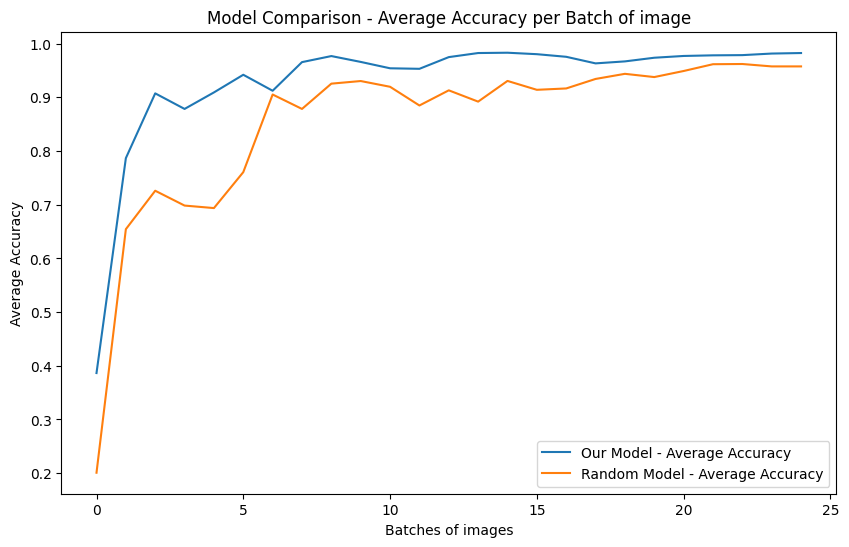

In [52]:
repeat_experiment(10, models, loaders)